## Quantitative trading in China A stock market with FinRL

<a target="_blank" href="https://colab.research.google.com/github/AI4Finance-Foundation/FinRL-Tutorials/blob/master/3-Practical/FinRL_China_A_Share_Market.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

Install FinRL

In [1]:
# !pip install wrds
# !pip install swig
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
# !pip install git+https://github.com/AI4Finance-Foundation/FinRL.git


Install other libraries

In [2]:
# !pip install stockstats
# !pip install tushare
#install talib
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz 
# !tar xvzf ta-lib-0.4.0-src.tar.gz
# import os
# os.chdir('ta-lib') 
# !./configure --prefix=/usr
# !make
# !make install
# os.chdir('../')
# !pip install TA-Lib

In [5]:
# %cd /
# !git clone https://github.com/AI4Finance-Foundation/FinRL-Meta
# %cd /FinRL-Meta/
%cd /Users/yutieyang/Documents/yuty/yuty_projects/money_game/RL/FinRL-Meta

/Users/yutieyang/Documents/yuty/yuty_projects/money_game/RL/FinRL-Meta


### Import modules

In [6]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
# from IPython import display
import IPython.display

from matplotlib_inline.backend_inline import set_matplotlib_formats
IPython.display.set_matplotlib_formats = set_matplotlib_formats
IPython.display.set_matplotlib_formats("svg")
# display.set_matplotlib_formats("svg")

from meta import config
from meta.data_processors.tushare import Tushare, ReturnPlotter
from meta.env_stock_trading.env_stocktrading_China_A_shares import StockTradingEnv
from agents.stablebaselines3_models import DRLAgent
pd.options.display.max_columns = None
    
print("ALL Modules have been imported!")

ALL Modules have been imported!


### Create folders

In [5]:
import os
if not os.path.exists("./datasets" ):
    os.makedirs("./datasets" )
if not os.path.exists("./trained_models"):
    os.makedirs("./trained_models" )
if not os.path.exists("./tensorboard_log"):
    os.makedirs("./tensorboard_log" )
if not os.path.exists("./results" ):
    os.makedirs("./results" )

### Download data, cleaning and feature engineering

In [6]:
ticket_list=['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH',
       '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH',
       '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH']

train_start_date='2015-01-01'
train_stop_date='2019-08-01'
val_start_date='2019-08-01'
val_stop_date='2021-01-03'

token='27080ec403c0218f96f388bca1b1d85329d563c91a43672239619ef5'

In [7]:
# download and clean
ts_processor = Tushare(data_source="tushare", 
                                   start_date=train_start_date,
                                   end_date=val_stop_date,
                                   time_interval="1d",
                                   token=token)
ts_processor.download_data(ticker_list=ticket_list)

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:08<00:00,  1.76it/s]

Download complete! Dataset saved to ./data/dataset.csv. 
Shape of DataFrame: (21574, 8)


In [8]:
ts_processor.clean_data()
ts_processor.fillna()
ts_processor.dataframe

Shape of DataFrame:  (21930, 8)


,tic,time,open,high,low,close,adjusted_close,volume
0,600000.SH,2015-01-05,15.88,16.25,15.56,16.07,16.07,5135687.09
1,600009.SH,2015-01-05,19.82,20.91,19.82,20.53,20.53,371485.54
2,600016.SH,2015-01-05,10.87,10.96,10.50,10.78,10.78,9138873.70
3,600028.SH,2015-01-05,6.59,7.14,6.45,7.14,7.14,11864996.45
4,600030.SH,2015-01-05,33.90,35.25,33.01,34.66,34.66,6986272.15
...,...,...,...,...,...,...,...,...
21925,600276.SH,2020-12-31,112.55,112.66,110.01,111.46,111.46,281568.85
21926,600309.SH,2020-12-31,89.88,91.48,88.70,91.04,91.04,213631.34
21927,600519.SH,2020-12-31,1941.00,1998.98,1939.00,1998.00,1998.00,38860.07
21928,600547.SH,2020-12-31,23.60,23.75,23.48,23.62,23.62,213786.94


In [9]:
# add_technical_indicator
ts_processor.add_technical_indicator(config.INDICATORS)
ts_processor.fillna()
ts_processor.dataframe

tech_indicator_list:  ['macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
indicator:  macd
indicator:  boll_ub
indicator:  boll_lb
indicator:  rsi_30
indicator:  cci_30
indicator:  dx_30
indicator:  close_30_sma
indicator:  close_60_sma
Succesfully add technical indicators
Shape of DataFrame:  (21885, 17)


,tic,time,index,open,high,low,close,adjusted_close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600000.SH,2015-01-08,45,15.87,15.88,15.20,15.25,15.25,3306271.72,-0.032571,16.617911,15.012089,6.058641,-125.593009,23.014040,15.815000,15.815000
1,600009.SH,2015-01-08,46,20.18,20.18,19.73,20.00,20.00,198117.45,-0.016008,20.663897,19.736103,12.828915,-90.842491,100.000000,20.200000,20.200000
2,600016.SH,2015-01-08,47,10.61,10.66,10.09,10.20,10.20,4851684.17,-0.018247,10.957604,9.997396,11.862558,-99.887006,100.000000,10.477500,10.477500
3,600028.SH,2015-01-08,48,7.09,7.41,6.83,6.85,6.85,8190902.35,-0.008227,7.342000,6.743000,27.409248,36.578171,64.934862,7.042500,7.042500
4,600030.SH,2015-01-08,49,36.40,36.70,34.68,35.25,35.25,6376268.69,0.032910,36.576444,33.808556,61.517448,47.947020,100.000000,35.192500,35.192500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21880,600276.SH,2020-12-31,21925,112.55,112.66,110.01,111.46,111.46,281568.85,5.999563,120.049291,81.980709,65.497668,108.629006,49.657169,96.356667,92.992167
21881,600309.SH,2020-12-31,21926,89.88,91.48,88.70,91.04,91.04,213631.34,1.723646,92.780907,79.425093,58.501768,115.410537,38.129756,85.693000,84.104667
21882,600519.SH,2020-12-31,21927,1941.00,1998.98,1939.00,1998.00,1998.00,38860.07,42.535547,1942.989267,1761.052733,66.422960,220.691463,52.684229,1815.039333,1761.921500
21883,600547.SH,2020-12-31,21928,23.60,23.75,23.48,23.62,23.62,213786.94,-0.252554,24.495355,23.032645,42.060734,-55.475296,0.003164,23.883667,24.534000


### Split traning dataset

In [10]:
train =ts_processor.data_split(ts_processor.dataframe, train_start_date, train_stop_date)       
len(train.tic.unique())

15

In [11]:
train.tic.unique()

array(['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH',
       '600031.SH', '600036.SH', '600050.SH', '600104.SH', '600196.SH',
       '600276.SH', '600309.SH', '600519.SH', '600547.SH', '600570.SH'],
      dtype=object)

In [19]:
train = train.rename(columns={'time': 'date'})

In [20]:
train.head()

,tic,date,index,open,high,low,close,adjusted_close,volume,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,600000.SH,2015-01-08,45,15.87,15.88,15.20,15.25,15.25,3306271.72,-0.032571,16.617911,15.012089,6.058641,-125.593009,23.014040,15.8150,15.8150
0,600009.SH,2015-01-08,46,20.18,20.18,19.73,20.00,20.00,198117.45,-0.016008,20.663897,19.736103,12.828915,-90.842491,100.000000,20.2000,20.2000
0,600016.SH,2015-01-08,47,10.61,10.66,10.09,10.20,10.20,4851684.17,-0.018247,10.957604,9.997396,11.862558,-99.887006,100.000000,10.4775,10.4775
0,600028.SH,2015-01-08,48,7.09,7.41,6.83,6.85,6.85,8190902.35,-0.008227,7.342000,6.743000,27.409248,36.578171,64.934862,7.0425,7.0425
0,600030.SH,2015-01-08,49,36.40,36.70,34.68,35.25,35.25,6376268.69,0.032910,36.576444,33.808556,61.517448,47.947020,100.000000,35.1925,35.1925


In [21]:
train.shape

(16695, 17)

In [22]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension*(len(config.INDICATORS)+2)+1
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 15, State Space: 151


### Train

In [23]:
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":False,
    # "initial_buy":True,
    "hundred_each_trade":True
}

e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## DDPG

In [26]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [27]:
agent = DRLAgent(env = env_train)
DDPG_PARAMS = {
                "batch_size": 256, 
               "buffer_size": 50000, 
               "learning_rate": 0.0005,
               "action_noise":"normal",
                }
POLICY_KWARGS = dict(net_arch=dict(pi=[64, 64], qf=[400, 300]))
model_ddpg = agent.get_model("ddpg", model_kwargs = DDPG_PARAMS, policy_kwargs=POLICY_KWARGS)

{'batch_size': 256, 'buffer_size': 50000, 'learning_rate': 0.0005, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}
Using cpu device


In [28]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                              tb_log_name='ddpg',
                              total_timesteps=10000)


Logging to tensorboard_log/ddpg/ddpg_1
Episode: 3
day: 1112, episode: 3
begin_total_asset: 1000000.00
end_total_asset: 4153950.88
total_reward: 3153950.88
total_cost: 12844.12
total_trades: 1332
Sharpe: 1.305
Episode: 4
day: 1112, episode: 4
begin_total_asset: 1000000.00
end_total_asset: 3702066.05
total_reward: 2702066.05
total_cost: 353.95
total_trades: 87
Sharpe: 1.178
Episode: 5
day: 1112, episode: 5
begin_total_asset: 1000000.00
end_total_asset: 2889566.26
total_reward: 1889566.26
total_cost: 224.74
total_trades: 54
Sharpe: 0.979
Episode: 6
day: 1112, episode: 6
begin_total_asset: 1000000.00
end_total_asset: 3487513.31
total_reward: 2487513.31
total_cost: 68.69
total_trades: 26
Sharpe: 1.114
-----------------------------------
| time/              |            |
|    episodes        | 4          |
|    fps             | 185        |
|    time_elapsed    | 23         |
|    total_timesteps | 4452       |
| train/             |            |
|    actor_loss      | -89.4      |
|    c

## A2C

In [ ]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [ ]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

Logging to tensorboard_log/a2c/a2c_1
--------------------------------------
| time/                 |            |
|    fps                | 193        |
|    iterations         | 100        |
|    time_elapsed       | 2          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -21.2      |
|    explained_variance | -1.19e-07  |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 36.2       |
|    reward             | 0.13071838 |
|    std                | 0.996      |
|    value_loss         | 3.94       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 193       |
|    iterations         | 200       |
|    time_elapsed       | 5         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -21.3     |
|    explained_variance | 0.0884   

### Trade

In [ ]:
trade = ts_processor.data_split(ts_processor.dataframe, val_start_date, val_stop_date)
env_kwargs = {
    "stock_dim": stock_dimension,
    "hmax": 1000, 
    "initial_amount": 1000000, 
    "buy_cost_pct":6.87e-5,
    "sell_cost_pct":1.0687e-3,
    "reward_scaling": 1e-4,
    "state_space": state_space, 
    "action_space": stock_dimension,
    "tech_indicator_list": config.INDICATORS, 
    "print_verbosity": 1,
    "initial_buy":False,
    "hundred_each_trade":True
}
e_trade_gym = StockTradingEnv(df = trade, **env_kwargs)

In [ ]:
df_account_value, df_actions = DRLAgent.DRL_prediction(model=trained_ddpg,
                       environment = e_trade_gym)

Episode: 2
day: 345, episode: 2
begin_total_asset: 1000000.00
end_total_asset: 1477113.54
total_reward: 477113.54
total_cost: 276.46
total_trades: 1733
Sharpe: 1.213
hit end!


In [ ]:
df_actions.to_csv("action.csv",index=False)
df_actions

,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600050.SH,600104.SH,600196.SH,600276.SH,600309.SH,600519.SH,600547.SH,600570.SH
date,,,,,,,,,,,,,,,
2019-08-01,0,0,0,1000,0,0,1000,1000,0,1000,1000,0,0,0,0
2019-08-02,0,0,0,1000,0,0,1000,1000,0,1000,1000,0,0,0,0
2019-08-05,0,0,0,1000,0,0,1000,1000,0,1000,1000,0,0,0,0
2019-08-06,0,0,0,1000,0,0,1000,1000,0,1000,1000,0,0,0,0
2019-08-07,0,0,0,1000,0,0,1000,1000,0,1000,1000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-12-28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Backtest

In [ ]:
# %matplotlib inline
plotter = ReturnPlotter(df_account_value, trade, val_start_date, val_stop_date)
# plotter.plot_all()

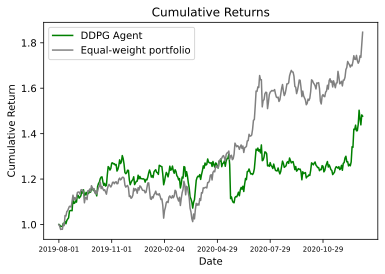

In [ ]:
%matplotlib inline
plotter.plot()

In [ ]:
# %matplotlib inline
# # ticket: SSE 50：000016
# plotter.plot("000016")

#### Use pyfolio

In [ ]:
# CSI 300
baseline_df = plotter.get_baseline("399300")

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


In [ ]:
import pyfolio
from pyfolio import timeseries
daily_return = plotter.get_return(df_account_value)
daily_return_base = plotter.get_return(baseline_df, value_col_name="close")

perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=daily_return, 
                              factor_returns=daily_return_base, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.328581
Cumulative returns     0.477114
Annual volatility      0.263881
Sharpe ratio           1.213204
Calmar ratio           1.853220
Stability              0.397236
Max drawdown          -0.177303
Omega ratio            1.240619
Sortino ratio          1.747191
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.235882
Daily value at risk   -0.031975
Alpha                 -0.013960
Beta                   0.789305
dtype: float64

In [ ]:
import pyfolio
from pyfolio import timeseries
daily_return = plotter.get_return(df_account_value)
daily_return_base = plotter.get_return(baseline_df, value_col_name="close")

perf_func = timeseries.perf_stats
perf_stats_all = perf_func(returns=daily_return_base, 
                              factor_returns=daily_return_base, 
                                positions=None, transactions=None, turnover_denom="AGB")
print("==============Baseline Strategy Stats===========")
perf_stats_all

==============Baseline Strategy Stats===========


Annual return          0.368688
Cumulative returns     0.318493
Annual volatility      0.214657
Sharpe ratio           1.576578
Calmar ratio           2.292911
Stability              0.798949
Max drawdown          -0.160795
Omega ratio            1.314981
Sortino ratio          2.356367
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.190306
Daily value at risk   -0.025701
Alpha                  0.000000
Beta                   1.000000
dtype: float64

In [ ]:
# with pyfolio.plotting.plotting_context(font_scale=1.1):
#         pyfolio.create_full_tear_sheet(returns = daily_return,
#                                        benchmark_rets = daily_return_base, set_context=False)

### Authors
github username: oliverwang15, eitin-infant